# TODO:
- ile potrzeba iteracji (random seach, bayes) do uzyskania stabilncyh wyników
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy
- określić i przeanalizować tunowalność CAŁYCH algorytmów
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias)

### Imports

In [4]:
import itertools
import random
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Integer, Real

from utills.dataset import load_dataset_from_id, split_dataset
from utills.pipeline import (
    evaluate_pipeline_on_datasets,
    get_bayes_model,
    get_column_transformer,
)

### Utill functions

In [55]:
from skopt import BayesSearchCV


def get_bayes_config(
    pipeline: Pipeline,
    search_space: Dict[str, Any],
    X: DataFrame,
    y: DataFrame,
    n_iter,
):

    opt: BayesSearchCV = get_bayes_model(pipeline, search_space, n_iter)
    opt.fit(X, y)
    iteration_scores = opt.cv_results_["mean_test_score"]

    # Optional: Print the score for each iteration
    for i, score in enumerate(iteration_scores):
        print(f"Iteration {i + 1}: Score = {score}")
    print(opt.n_iter)
    return dict(opt.best_params_)

In [7]:
def evaluate_model_performance(
    model: Pipeline, X_train, y_train, X_test, y_test
) -> float:
    model.fit(
        X=X_train,
        y=y_train,
    )
    return model.score(
        X=X_test,
        y=y_test,
    )

In [8]:
def experiment(
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    config,
) -> List[float]:
    performances: List[float] = []
    for (X_train, y_train), (X_test, y_test) in zip(train_datasets, test_datasets):
        model.set_params(**config)
        performance: float = evaluate_model_performance(
            model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
        )
        performances.append(performance)
    return performances

In [9]:
def find_optimal_configuration_for_all_datasets(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    summary_func,
):
    best_config = None
    best_summary_score = float("0")
    last_idx_of_config_with_significant_imporvement = -1
    for idx, config in enumerate(config_space):
        performances = experiment(
            train_datasets=train_datasets,
            test_datasets=test_datasets,
            model=model,
            config=config,
        )
        summary_score = summary_func(performances)

        if summary_score > best_summary_score:
            if abs(summary_score - best_summary_score) > 0.01:
                last_idx_of_config_with_significant_imporvement = idx
                best_summary_score = summary_score
                best_config = config

    return (best_config, last_idx_of_config_with_significant_imporvement)

In [10]:
def find_optimal_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    model: Pipeline,
):
    best_config = None
    best_score = float("0")

    for config in config_space:
        # model = get_model_func()
        model.set_params(**config)
        score: float = evaluate_model_performance(
            model=model,
            X_train=train_dataset[0],
            y_train=train_dataset[1],
            X_test=test_dataset[0],
            y_test=test_dataset[1],
        )

        if score > best_score:
            best_score = score
            best_config = config

    return best_config

In [11]:
def find_optimal_bayes_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    pipeline: Pipeline,
    retries: int = 1,
):
    best_config = None
    best_score = float("0")
    steps = -1

    for config in config_space:
        for _ in range(retries):
            cnf = get_bayes_config(pipeline, config, train_dataset[0], train_dataset[1])

            pipeline.set_params(**cnf)
            score: float = evaluate_model_performance(
                model=pipeline,
                X_train=train_dataset[0],
                y_train=train_dataset[1],
                X_test=test_dataset[0],
                y_test=test_dataset[1],
            )

            if score > best_score:
                best_score = score
                best_config = cnf

    return (best_config, steps)

In [13]:
def find_optimal_bayes_config_for_each_dataset(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    pipeline: Pipeline,
    retries: int = 1,
):
    configs = []
    for train, test in zip(train_datasets, test_datasets):
        cnf = find_optimal_bayes_config_for_dataset(
            config_space, train, test, pipeline, retries
        )
        configs.append(cnf[0])
    return configs

In [54]:
def configs_from_candidates(candidates, pipeline: Pipeline, train_datasets, retries):
    configs = []
    for config in candidates:
        for train in train_datasets:
            for _ in range(retries):
                cnf = get_bayes_config(
                    pipeline, config[0][0], train[0], train[1], config[0][1]
                )
                configs.append(cnf)
    return configs

### Load datasets

In [15]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
liver_disorders_dataset_id = (
    8  # https://www.openml.org/search?type=data&id=8&sort=runs&status=active
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)


fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

liver_disorders_dataset: DataFrame = load_dataset_from_id(id=liver_disorders_dataset_id)
liver_disorders_regression_class = "drinks"
diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [16]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_liver_disorders,
    X_test_liver_disorders,
    y_train_liver_disorders,
    y_test_liver_disorders,
) = split_dataset(data=liver_disorders_dataset, class_=liver_disorders_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

In [17]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_liver_disorders, y_train_liver_disorders),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
    ]

In [18]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_liver_disorders, y_test_liver_disorders),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
    ]

### TODO: visualize the data

### Create generic column transformer

### Create pipelines

#### 1. Decision Tree

In [19]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [23]:
def get_configuration_grid_decision_tree():
    # parameters space
    random.seed(42)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

In [24]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
test_datasets: List[Tuple[DataFrame, Series]] = get_test_datasets()
decison_tree_pipeline: Pipeline = get_decision_tree_pipeline()
configuration_grid_decision_tree = get_configuration_grid_decision_tree()

In [25]:
# find teta*

(
    optimal_config_decision_tree,
    last_idx_of_config_with_significant_imporvement,
) = find_optimal_configuration_for_all_datasets(
    config_space=configuration_grid_decision_tree,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=decison_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)

In [26]:
print(optimal_config_decision_tree)
print(last_idx_of_config_with_significant_imporvement)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

{'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
46


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000189AF8EAE50>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000189AF8A4D90>)])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.7000000000000001,
                                       max_depth=5, min_samples_leaf=4,
                                       min_samples_split=16))])

In [27]:
def get_best_configs_for_each_set(
    pipeline: Pipeline, config_space, train_datasets, test_datasets
):
    best_configs = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        best_config = find_optimal_config_for_dataset(
            config_space=config_space,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            model=pipeline,
        )
        best_configs.append(best_config)
        pipeline.set_params(**best_config)
        pipeline.fit(train_dataset[0], train_dataset[1])
        print("score: " + str(pipeline.score(test_dataset[0], test_dataset[1])))
        print("best config: " + str(best_config))
    return best_configs

In [28]:
# find tate^(j)*
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_configuration_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

score: 0.9643548213621457
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}
score: 0.1878010532545623
best config: {'model__ccp_alpha': 0.2, 'model__max_depth': 25, 'model__min_samples_split': 39, 'model__min_samples_leaf': 44}
score: 0.46184442507636947
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 18, 'model__min_samples_split': 51, 'model__min_samples_leaf': 6}
score: 0.698117764128138
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}


In [29]:
def calculate_tunability_on_each_set(train_datasets, test_datasets, best_configs):
    tunability = []
    for train_dataset, test_dataset, best_config in zip(
        train_datasets, test_datasets, best_configs
    ):
        optimal_decision_tree.fit(train_dataset[0], train_dataset[1])
        best_decision_tree_for_dataset = get_decision_tree_pipeline()
        best_decision_tree_for_dataset.set_params(**best_config)
        best_decision_tree_for_dataset.fit(train_dataset[0], train_dataset[1])
        tunability_on_dataset = best_decision_tree_for_dataset.score(
            test_dataset[0], test_dataset[1]
        ) - optimal_decision_tree.score(test_dataset[0], test_dataset[1])
        tunability.append(tunability_on_dataset)
        print("d^j: " + str(tunability_on_dataset))
    return tunability

In [30]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

d^j: 0.0
d^j: 0.12012499127253262
d^j: 0.0945803993458324
d^j: 0.0


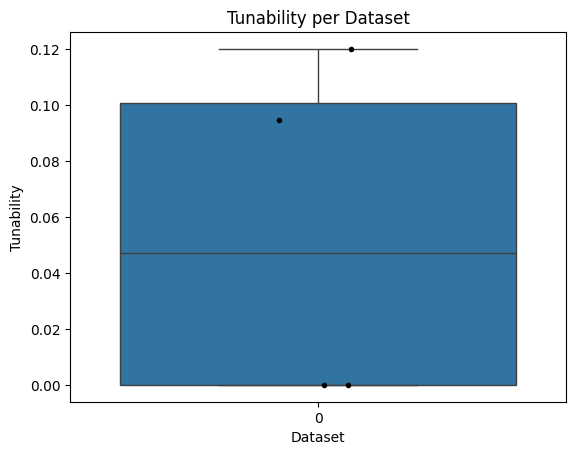

In [31]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

In [32]:
# aggregated tunability d
print("Aggregated tunability d: " + str(np.mean(tunability_on_datasets)))

Aggregated tunability d: 0.053676347654591255


In [33]:
def calculate_scores_for_pipeline(pipeline: Pipeline, train_datasets, test_datasets):
    scores = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        pipeline.fit(train_dataset[0], train_dataset[1])
        score = pipeline.score(test_dataset[0], test_dataset[1])
        scores.append(score)
        print("score: " + str(score))

In [34]:
calculate_scores_for_pipeline(
    optimal_decision_tree, get_train_datasets(), get_test_datasets()
)

score: 0.9643548213621457
score: 0.06767606198202969
score: 0.36726402573053707
score: 0.698117764128138


Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.7815269691092457
Train score R^2: 0.7815269691092457
Mean Squared Error: 26856.500884781224


Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.15528101406816253
Train score R^2: 0.15528101406816253
Mean Squared Error: 9.48162852008955
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5221465690813645
Train score R^2: 0.5221465690813645
Mean Squared Error: 2903.6276381318785
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5595820029015193
Train score R^2: 0.5595820029015193
Mean Squared Error: 89991302260.828
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.789919150538415
Train score R^2: 0.789919150538415
Mean Squared Error: 25824.864956727335
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_sampl

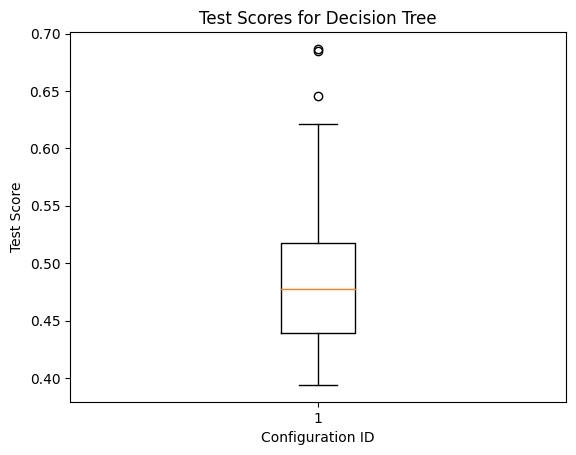

Best Configuration: {'model__ccp_alpha': 0.4, 'model__max_depth': 11, 'model__min_samples_split': 8, 'model__min_samples_leaf': 7}
Best Test Score: 0.6866351370414695


In [35]:
test_scores = (
    []
)  # list of test scores calculated across datasets, for each configuration
config_ids = []
best_config = None
best_test_score = float("-inf")

for i, config in enumerate(configuration_grid_decision_tree):
    results = evaluate_pipeline_on_datasets(
        get_decision_tree_pipeline(), config, train_datasets
    )

    aggregated_test_score = np.mean([result[0] for result in results])
    test_scores.append(aggregated_test_score)
    config_ids.append(i)

    if aggregated_test_score > best_test_score:
        best_test_score = aggregated_test_score
        best_config = config

plt.boxplot(test_scores)
plt.xlabel("Configuration ID")
plt.ylabel("Test Score")
plt.title("Test Scores for Decision Tree")
plt.show()

print("Best Configuration:", best_config)
print("Best Test Score:", best_test_score)

#### Bayes

In [36]:
def get_bayes_config_candidates_decision_tree():
    return [
        [
            (
                {
                    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
                    "model__max_depth": Integer(1, 31, prior="log-uniform"),
                    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
                    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
                },
                100,
            )
        ],
        # [
        #     (
        #         {
        #             "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
        #             "model__max_depth": Integer(1, 31, prior="log-uniform"),
        #             "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
        #             "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
        #         },
        #         20,
        #     )
        # ],
        # [
        #     (
        #         {
        #             "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
        #             "model__max_depth": Integer(1, 31, prior="log-uniform"),
        #             "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
        #             "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
        #         },
        #         30,
        #     )
        # ],
    ]

In [56]:
candidates = get_bayes_config_candidates_decision_tree()

# calculate all configs
configs = configs_from_candidates(
    candidates=candidates,
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
    retries=1,
)

Iteration 1: Score = 0.7819467475731763
Iteration 2: Score = 0.6465515830899411
Iteration 3: Score = 0.6310443819100943
Iteration 4: Score = 0.6373197179989203
Iteration 5: Score = 0.6427803119369069
Iteration 6: Score = -0.05320919309927987
Iteration 7: Score = 0.6397575960991398
Iteration 8: Score = 0.7819467475731763
Iteration 9: Score = 0.7455002670510849
Iteration 10: Score = 0.8548890922376348
10
Iteration 1: Score = -0.0496693269953399
Iteration 2: Score = -0.10927661751029953
Iteration 3: Score = -0.0496693269953399
Iteration 4: Score = -0.06270537586976677
Iteration 5: Score = -0.06270537586976677
Iteration 6: Score = -0.060553349986188706
Iteration 7: Score = -0.06270537586976677
Iteration 8: Score = -0.06270537586976677
Iteration 9: Score = -0.0656894294435461
Iteration 10: Score = -0.029754343171849794
10
Iteration 1: Score = 0.23219900167516264
Iteration 2: Score = 0.35160918571106714
Iteration 3: Score = 0.319287802067998
Iteration 4: Score = 0.3401131876766965
Iteration 

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.2162773283562327
Iteration 2: Score = 0.35160918571106714
Iteration 3: Score = 0.3327751402872316
Iteration 4: Score = 0.2404246602476212
Iteration 5: Score = 0.30969437241503417
Iteration 6: Score = 0.35160918571106714
Iteration 7: Score = 0.2777213895233048
Iteration 8: Score = 0.30496289747139793
Iteration 9: Score = 0.17144303569970357
Iteration 10: Score = 0.23219900167516264
Iteration 11: Score = 0.319287802067998
Iteration 12: Score = 0.35160918571106714
Iteration 13: Score = 0.35160918571106714
Iteration 14: Score = 0.35160918571106714
Iteration 15: Score = 0.3431891488526617
Iteration 16: Score = 0.012601529252501197
Iteration 17: Score = 0.319287802067998
Iteration 18: Score = 0.23219900167516264
Iteration 19: Score = 0.319287802067998
Iteration 20: Score = 0.319287802067998
Iteration 21: Score = 0.23219900167516264
Iteration 22: Score = 0.319287802067998
Iteration 23: Score = 0.35160918571106714
Iteration 24: Score = 0.35160918571106714
Iteration 25: S

In [41]:
# find optimal theta

(
    optimal_config,
    last_idx_of_config_with_significant_improvement,
) = find_optimal_configuration_for_all_datasets(
    config_space=configs,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=get_decision_tree_pipeline(),
    summary_func=np.mean,
)

In [42]:
print(optimal_config)
print(last_idx_of_config_with_significant_improvement)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

{'model__ccp_alpha': 0.23296518681616513, 'model__max_depth': 4, 'model__min_samples_leaf': 12, 'model__min_samples_split': 32}
15


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000189AFA6CF70>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000189AD1CDCD0>)])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.7000000000000001,
                                       max_depth=5, min_samples_leaf=4,
                                       min_samples_split=16))])

In [43]:
# find theta^(j)
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=configs,
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

score: 0.9630306807645214
best config: {'model__ccp_alpha': 0.8047339903497972, 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 3}
score: 0.16160537465256997
best config: {'model__ccp_alpha': 0.13363717240429412, 'model__max_depth': 19, 'model__min_samples_leaf': 54, 'model__min_samples_split': 54}
score: 0.43484489814756955
best config: {'model__ccp_alpha': 0.6452511101720104, 'model__max_depth': 21, 'model__min_samples_leaf': 5, 'model__min_samples_split': 48}
score: 0.6848200051719223
best config: {'model__ccp_alpha': 1.21, 'model__max_depth': 16, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3}


In [44]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

d^j: -0.0013241405976243126
d^j: 0.09392931267054028
d^j: 0.06758087241703248
d^j: -0.014847438829052262


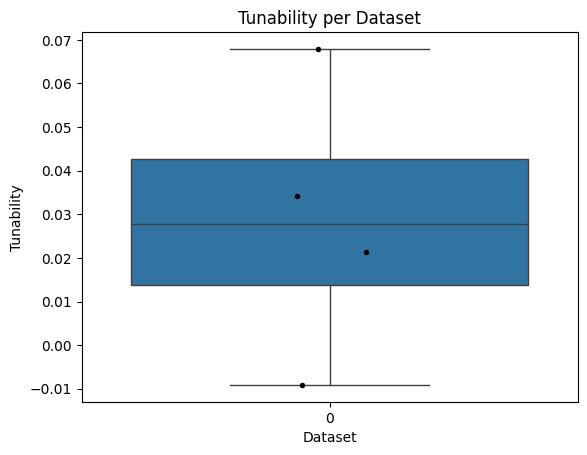

In [ ]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

#### 2. ElasticNet

In [ ]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [ ]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(42)
    alpha = [i * 0.05 for i in range(21)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
elastic_net_pipeline: Pipeline = get_elasticnet_pipeline()
parameters_grid_elasticnet = get_parameter_grid_for_elasticnet()
optimal_config_elasticnet = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_elasticnet,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=elastic_net_pipeline,
    summary_func=np.mean,
)

C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\adamd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider i

In [ ]:
print(optimal_config_elasticnet)

({'model__alpha': 0.05, 'model__l1_ratio': 0.9500000000000001}, 60)


In [ ]:
evaluate_pipeline_on_datasets(
    get_elasticnet_pipeline(), optimal_config_elasticnet, train_datasets
)

TypeError: sklearn.pipeline.Pipeline.set_params() argument after ** must be a mapping, not tuple

#### 3. Random Forest

In [ ]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [ ]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(42)
    max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 61, 1)
    min_samples_leaf_values = range(1, 61, 1)
    n_estimators_values = range(1, 200, 1)

    all_combinations = list(
        itertools.product(
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
random_forest_pipeline: Pipeline = get_random_forest_pipeline()
parameters_grid_random_forest = get_parameter_grid_for_random_forest()

optimal_config_random_forest = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_random_forest,
    train_datasets=train_datasets,
    model=random_forest_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_random_forest)

In [ ]:
evaluate_pipeline_on_datasets(
    get_random_forest_pipeline(), optimal_config_random_forest, train_datasets
)

#TODO
- dla każdej konfiguracje z paratmers_grid trzeba ją porównać do optymalnej

### Bayes - decision tree

In [ ]:
decision_tree_params = {
    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
    "model__max_depth": Integer(1, 31, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
}

OrderedDict([('model__ccp_alpha', 0.11), ('model__max_depth', 17), ('model__min_samples_leaf', 2), ('model__min_samples_split', 7)])
30


In [ ]:
config = get_bayes_config(
    get_decision_tree_pipeline(),
    [(decision_tree_params, 40)],
    X_train_fish_market,
    y_train_fish_market,
)
model = get_decision_tree_pipeline()
model.set_params(**config)
model.fit(X_train_fish_market, y_train_fish_market)
score = model.score(X_test_fish_market, y_test_fish_market)
print(score)

0.9511259336021848
